In [1]:
import pandas as pd
import numpy as np
np.seterr(divide = 'ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
from sklearn.preprocessing import StandardScaler

In [3]:
df=pd.read_csv('dataset/decision-tree.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [7]:
sc_X = StandardScaler()
columnList=list(df.columns)
columnList.pop()
X =  pd.DataFrame(sc_X.fit_transform(df.drop(["Outcome"],axis = 1)), columns=columnList)
X['Outcome']=df['Outcome']
df=X
X.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.639947,0.848324,0.149641,0.907270,-0.692891,0.204013,0.468492,1.425995,1
1,-0.844885,-1.123396,-0.160546,0.530902,-0.692891,-0.684422,-0.365061,-0.190672,0
2,1.233880,1.943724,-0.263941,-1.288212,-0.692891,-1.103255,0.604397,-0.105584,1
3,-0.844885,-0.998208,-0.160546,0.154533,0.123302,-0.494043,-0.920763,-1.041549,0
4,-1.141852,0.504055,-1.504687,0.907270,0.765836,1.409746,5.484909,-0.020496,1


In [8]:
class Node:
    def __init__(self,feature,threshold,gain,left,right,depth,value)->None:
        self.feature=feature
        self.threshold=threshold
        self.gain=gain
        self.left=left
        self.right=right
        self.depth=depth
        self.value=value

class DecisionTree:
    def __init__(self):
        self.tree=None
        self.error_set=[]
        self.depth=[]
    
    def best_split(self,df):
        df=df.reset_index().drop(['index'],axis=1)
        features=list(df.columns)
        rFeature=features.pop()
        tot=df.shape[0]
        if(tot==0):
            return 0
        pEntropy=self.entropy(df,rFeature)
        bestIG={}
        bestSplit={}
        #print(features, rFeature)
        for feature in features:
            df2=df.sort_values(feature)
            res=df2[rFeature].to_numpy()
            #print(res)
            split_points=[]
            for i in range(1,len(res)):
                #print("Indide loop")
                if(res[i]!=res[i-1]):
                    value = (df2[feature][i]+df2[feature][i-1])/2
                    #print(value)
                    split_points.append(value)
            #print("Calculated split points")
            split_points=list(set(split_points))
            split_points.sort()
            IGS={}    
            for v in  split_points:
                #print(f"value {v}")
                df1=df[df[feature]<=v]
                df2=df[df[feature]>v]
                if(df1.shape[0]<10 or df2.shape[0]<10):
                    continue
                lTot=df1.shape[0]
                lEntropy=self.entropy(df1,rFeature)
                rTot=df2.shape[0]
                rEntropy=self.entropy(df2,rFeature) 
                IG=(pEntropy-((lTot/tot)*lEntropy)-((rTot/tot)*rEntropy))
                IGS[v]=IG
                #print(f"v:{v} IG:{IG}")
            #print("IGs calculated for all split points")    
            if(len(IGS)!=0):
                k=max(zip(IGS.values(),IGS.keys()))[1]
                #print(k)
                bestIG[feature]=IGS[k]
                bestSplit[feature]=k
        if(len(bestIG)!=0):
            f=max(zip(bestIG.values(),bestIG.keys()))[1]
            #print("Best calculated")
            return f,bestIG[f],bestSplit[f]
        return None,-1,-1
                  
    def entropy(self, data, rFeature):
        #print(data[rFeature].value_counts())
        a=(data[rFeature]==0).sum()
        b=(data[rFeature]==1).sum()
        if(a+b == 0):
            return 0
        p1=a/(a+b)
        p2=b/(a+b)
        e=0
        if(p1!=0):
            e = (-p1)*(np.log2(p1))
        if(p2!=0):
            e += (-p2)*(np.log2(p2))
        return e
    
    def fscore(self,Y,Y_Pred):
        TP0=0
        FP0=0
        FN0=0
        TP1=0
        FP1=0
        FN1=0
        for i in range(len(Y)):
            if(Y[i]==1 and Y_Pred[i]==1):
                TP0+=1
            if(Y[i]==1 and Y_Pred[i]==0):
                FN1+=1
                FP0+=1
            if(Y[i]==0 and Y_Pred[i]==1):
                FP1+=1
                FN0+=1
            if(Y[i]==0 and Y_Pred[i]==0):
                TP1+=1
        precision0=TP0/(TP0+FP0)
        precision1=TP1/(TP1+FP1)
        recall0=TP0/(TP0+FN0)
        recall1=TP1/(TP1+FN1)
        accuracy0=(TP0)/(TP0+FP0+FN0)
        accuracy1=(TP1)/(TP1+FP1+FN1)
        return (precision0+precision1)/2, (recall0+recall1)/2, (accuracy0+accuracy1)/2
    
    def accuracy(self,Y,Y_Pred):
        TP=0
        FP=0
        FN=0
        TN=0
        for i in range(len(Y)):
            if(Y[i]==1 and Y_Pred[i]==1):
                TP+=1
            if(Y[i]==1 and Y_Pred[i]==0):
                FN+=1
            if(Y[i]==0 and Y_Pred[i]==1):
                FP+=1
            if(Y[i]==0 and Y_Pred[i]==0):
                TN+=1
        accuracy=(TP)/(TP+FP+FN+TN)
        return accuracy
    
    def build_tree(self,df,current_depth=0):
        feature,IG,val=self.best_split(df)
        if(feature == None):
            Y=list(df['Outcome'])
            pred_value=max(Y, key=Y.count)
            self.tree=Node(feature,val,IG,None,None,current_depth,pred_value)
            return current_depth
        #print("Going Left")
        left=DecisionTree()
        dL=left.build_tree(df[df[feature]<=val],current_depth+1)
        #print("Going Right")
        right=DecisionTree()
        dr=right.build_tree(df[df[feature]>val],current_depth+1)
        Y=list(df['Outcome'])
        pred_value=max(Y, key=Y.count)
        self.tree=Node(feature,val,IG,left,right,current_depth,pred_value)
        return max(dL,dr)
    
    def predict(self,data,depth=None):
        root=self.tree
        if(root == None):
            return None
        cRoot=root
        cFeature=root.feature
        cThreshold=root.threshold
        while(root!=None):
            cFeature=root.feature
            cThreshold=root.threshold
            if(depth!=None and root.depth == depth):
                break
            if(root.left==None or root.right==None):
                break
            cRoot=root
            if(data[cFeature]<=cThreshold ):
                root=root.left.tree
            else:
                root=root.right.tree
            if(root == None):
                root=cRoot
                break
        return root.value
    
    def test(self,data,depth=None):
        Y_Pred=[]
        for i in range(data.shape[0]):
            Y_Pred.append(self.predict(data.iloc[i],depth))
        accuracy=self.accuracy(list(data['Outcome']),Y_Pred)
        return accuracy
    def train(self,train,val):
        trainaccuracy=[]
        valaccuracy=[]
        depth=[]
        maxDepth=self.build_tree(train)
        for i in (range(maxDepth+1)):
            depth.append(i)
            accuracy1=self.test(train,i)
            accuracy2=self.test(val,i)
            trainaccuracy.append(accuracy1)
            valaccuracy.append(accuracy2)
        return depth, trainaccuracy, valaccuracy
    def prune(self, tree, depth):
        if(tree == None or tree.feature == None):
            return
        if(tree.depth == depth):
            tree.left=None
            tree.right=None
            return
        self.prune(tree.left.tree,depth)
        self.prune(tree.right.tree,depth)
        return tree
    def pruneTree(self,depth):
        self.tree=self.prune(self.tree, depth)

In [9]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

In [10]:
train=train.reset_index().drop(['index'],axis=1)
test=test.reset_index().drop(['index'],axis=1)

In [11]:
dTree=DecisionTree()

In [12]:
depth,trainAccuracy,valAccuracy=dTree.train(train,test)

In [13]:
depth

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [14]:
trainAccuracy

[0.0,
 0.22149837133550487,
 0.19218241042345277,
 0.19218241042345277,
 0.26384364820846906,
 0.23615635179153094,
 0.24429967426710097,
 0.23615635179153094,
 0.23615635179153094]

In [15]:
valAccuracy

[0.0,
 0.24675324675324675,
 0.21428571428571427,
 0.21428571428571427,
 0.24675324675324675,
 0.22077922077922077,
 0.22727272727272727,
 0.2077922077922078,
 0.2077922077922078]

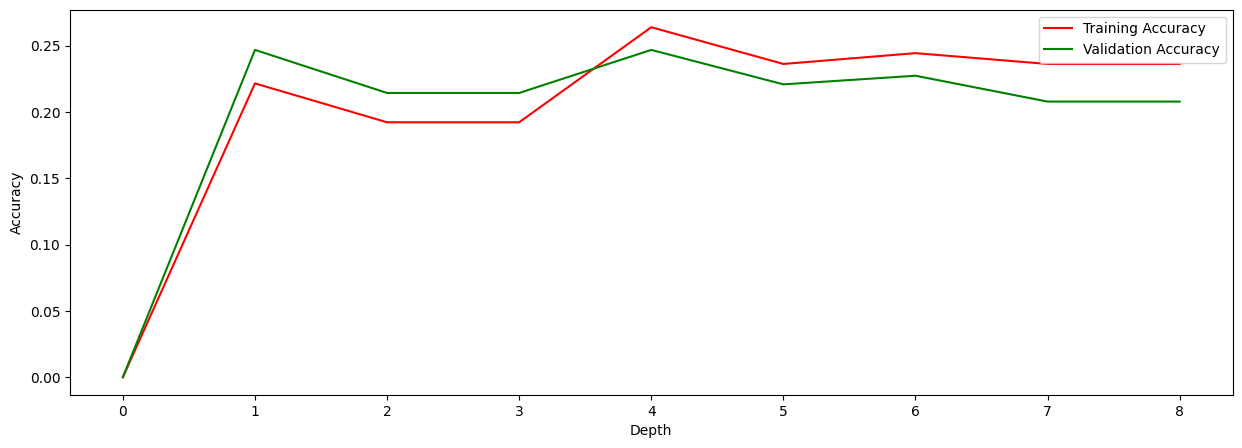

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.plot(depth,trainAccuracy,color='r')
plt.plot(depth,valAccuracy,color='g')
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.show()


In [17]:
def print_tree(decisionTree, indent="", is_right=False):
    if(decisionTree == None):
        return
    feature, threshold = decisionTree.tree.feature, decisionTree.tree.threshold
    left_subtree, right_subtree = decisionTree.tree.left, decisionTree.tree.right
    value=decisionTree.tree.value
    marker = "└── " if is_right else "├── "
    if(feature!=None):
        print(indent + marker + f"{feature} <= {threshold} Predicted Class:{value}")
    else:
        print(indent + marker + f"Predicted Class: {value}")
    marker = "└── " if is_right else "├── "
    if(decisionTree.tree == None or decisionTree.tree.feature == None):
        return
    new_indent = indent + ("    " if is_right else "│   ")
    print_tree(left_subtree, new_indent)
    print_tree(right_subtree, new_indent, is_right=True)

In [18]:
print_tree(dTree)

├── Glucose <= 0.2067323154221899 Predicted Class:0
│   ├── BMI <= -0.7351896442998047 Predicted Class:0
│   │   ├── BloodPressure <= -1.6339316187784494 Predicted Class:0
│   │   │   ├── Predicted Class: 0
│   │   │   └── Predicted Class: 0
│   │   └── Age <= -0.31830353483853857 Predicted Class:0
│   │       ├── Pregnancies <= 0.0460143347184071 Predicted Class:0
│   │       │   ├── BMI <= 0.032671790113532884 Predicted Class:0
│   │       │   │   ├── SkinThickness <= 0.34271737544497916 Predicted Class:0
│   │       │   │   │   ├── Predicted Class: 0
│   │       │   │   │   └── Predicted Class: 0
│   │       │   │   └── DiabetesPedigreeFunction <= 0.029064709823357182 Predicted Class:0
│   │       │   │       ├── DiabetesPedigreeFunction <= -0.9086821394956773 Predicted Class:0
│   │       │   │       │   ├── Predicted Class: 0
│   │       │   │       │   └── SkinThickness <= 0.40544543653691056 Predicted Class:0
│   │       │   │       │       ├── Predicted Class: 0
│   │       │  

In [19]:
dTree.pruneTree(5)

In [20]:
print_tree(dTree)

├── Glucose <= 0.2067323154221899 Predicted Class:0
│   ├── BMI <= -0.7351896442998047 Predicted Class:0
│   │   ├── BloodPressure <= -1.6339316187784494 Predicted Class:0
│   │   │   ├── Predicted Class: 0
│   │   │   └── Predicted Class: 0
│   │   └── Age <= -0.31830353483853857 Predicted Class:0
│   │       ├── Pregnancies <= 0.0460143347184071 Predicted Class:0
│   │       │   ├── BMI <= 0.032671790113532884 Predicted Class:0
│   │       │   │   ├── SkinThickness <= 0.34271737544497916 Predicted Class:0
│   │       │   │   └── DiabetesPedigreeFunction <= 0.029064709823357182 Predicted Class:0
│   │       │   └── Glucose <= -0.4974534544369548 Predicted Class:0
│   │       │       ├── Predicted Class: 0
│   │       │       └── Predicted Class: 0
│   │       └── Glucose <= -0.41921059111927206 Predicted Class:0
│   │           ├── BMI <= 0.8449549604020217 Predicted Class:0
│   │           │   ├── SkinThickness <= 0.6877217114506016 Predicted Class:0
│   │           │   └── Predicted

In [21]:
def metrics(test):
        Y_Pred=[]
        for i in range(test.shape[0]):
            Y_Pred.append(dTree.predict(test.iloc[i]))
        macroPrecision, macroRecall, macroAccuracy=dTree.fscore(list(test['Outcome']),Y_Pred)
        print(f"Mean-Macro-Precision: {macroPrecision}\nMean-Macro-Recall: {macroRecall}\nMean-Macro-Accuracy: {macroAccuracy}")
metrics(test)

Mean-Macro-Precision: 0.7045617816091954
Mean-Macro-Recall: 0.7168284789644013
Mean-Macro-Accuracy: 0.5558333333333333
